In [1]:
!pip install unidecode
!pip install underthesea
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 4.3 MB/s eta 0:00:00


In [2]:
import re
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

from underthesea import word_tokenize
from unidecode import unidecode
import emoji
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, GlobalMaxPooling1D, LayerNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, save_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

#**1. Data Collection: Crawling by Json request for data sample**


In [ ]:
url = "https://shopee.vn/Son-Kem-Black-Rouge-Air-Fit-Velvet-Tint-Ver-2-36.6g-i.182549544.2899625373?sp_atk=b0cfd561-c0f5-45eb-8090-5fbff8ba8cb2&xptdk=b0cfd561-c0f5-45eb-8090-5fbff8ba8cb2"

#get shopid and itemid
r = re.search(r"i\.(\d+)\.(\d+)", url)
shop_id, item_id = r[1], r[2]

ratings_url = "https://shopee.sg/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=20&offset={offset}&shopid={shop_id}&type=0"
offset = 0
d = {"username": [], "rating": [], "comment": []}
i = 1  # Initialize i to 1

while i<=3000:
    data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset)).json()

    if data["data"]["ratings"] is not None:
        for rating in data["data"]["ratings"]:
            d["username"].append(rating["author_username"])
            d["rating"].append(rating["rating_star"])
            d["comment"].append(rating["comment"])
            i+=1
    offset += 20

df = pd.DataFrame(d)
df

,username,rating,comment
0,huyntrang_1612,5,Lợi ích:dùng\nHiệu ứng làm đẹp:đánh lên môi\nL...
1,trucphann19,5,Độ bền màu:dễ trôi\nCông dụng:son môi\n\nMàu A...
2,linnhhkhnh344,5,Công dụng:chét mỏ đó\nĐộ bền màu:bình thường\n...
3,nhunggphi085,5,3 năm nay mình chỉ trung thành với em này thui...
4,r6d7ey7ipw,5,Kết cấu:ko rõ lắm\nĐộ bền màu:khá bền\nCông dụ...
...,...,...,...
2995,mai_anh_vu_682,5,son xinh lắm lun :33
2996,chiiiha,5,Khưm em cũng vậy hả em có tiền về cho con gái ...
2997,hienchau1307,5,
2998,_cheese.2210_,5,


In [32]:
df = pd.read_csv('Shopee_Crawl_Review.csv')
df.head()

,username,rating,comment
0,lananh090903,2,"Cực kì thất vọng về màu son, màu lên không hề ..."
1,314m_eaqz0,1,Bthg vẫn mua nguyên si giá thấy chất son oke b...
2,mmmai1303,1,Công dụng:làm hồng môi\nĐộ bền màu:chưa bt\n\n...
3,b86cww4fkh,2,"Mở ra thì đầu cọ bị rớt trong lọ son, không sử..."
4,tinhbaominh,1,Mùi son khá ổn. Mình biết môi mình khá nhạy cả...


In [33]:
'''
score <= 3 : Negative
score 4-5: Positive
'''
df['label'] = df['rating'].apply(lambda rating: 'Negative' if rating <= 3 else 'Positive')
df.drop(columns = ['username','rating'], inplace = True)
df.head()

,comment,label
0,"Cực kì thất vọng về màu son, màu lên không hề ...",Negative
1,Bthg vẫn mua nguyên si giá thấy chất son oke b...,Negative
2,Công dụng:làm hồng môi\nĐộ bền màu:chưa bt\n\n...,Negative
3,"Mở ra thì đầu cọ bị rớt trong lọ son, không sử...",Negative
4,Mùi son khá ổn. Mình biết môi mình khá nhạy cả...,Negative


<Axes: xlabel='label', ylabel='count'>

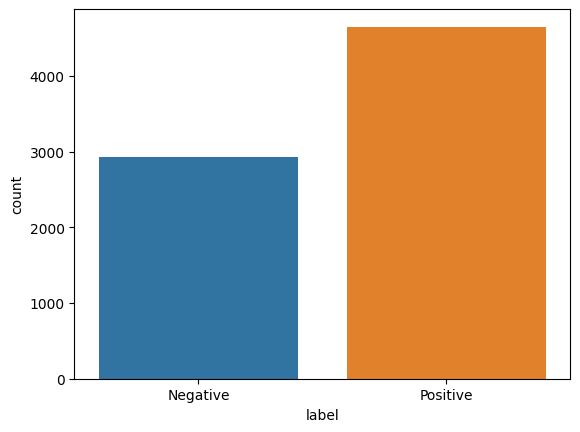

In [34]:
sns.countplot(data=df, x='label')

# **2. Data Preprocessing**

**2.1. Text cleaning and Tokenization**

In [5]:
def cleaning(text):
    #lower word
    text = text.lower()
    #remove newline characters
    text = re.sub(r'\n', ' ', text)
    #remove special characters
    text = re.sub(r'[.,;:?!()\[\]{}<>^~`\-_\'/@#$%&*+=|\\]', ' ', text)
    #remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
     #replace teencode and replace emoji
    teencode_dict = {
                    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',
                    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng',
                    'fake': 'giả mạo', 'pha ke': 'giả mạo',
                    'ô kêi': 'tốt', 'okie': 'tốt', 'o kê': 'tốt', 'okey': 'tốt', 'ôkê': 'tốt', 'oki': 'tốt', 'oke': 'tốt', 'okay': 'tốt', 'okê': 'tốt',
                    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
                    'kg': 'không', 'hk': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
                    'cc': 'tiêu cực','cccc': 'tiêu cực', 'huhu': 'tiêu cực',
                    'gud': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
                    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
                    'fback': 'feedback', 'fedback': 'feedback',
                    'sd': 'sử dụng', 'sài': 'xài',
                    'sp': 'sản phẩm'
                    }
# !wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
    with open('teencode.txt','r', encoding='utf-8') as file:
        for line in file:
            key, value = line.strip().split('\t')
            teencode_dict[key]=value
    words = []
    for w in text.split():
        if w not in teencode_dict.keys():
            words.append(w)
        else: words.append(teencode_dict[w])
    text = emoji.replace_emoji(' '.join(words), replace='')
    #remove continuous duplicate characters and replace with 1st charector in the group.
    text = re.sub(r'(\w)\1+', r'\1', text, flags=re.IGNORECASE)
    return text

In [35]:
input_data = df['comment'].values
input_label = df['label'].values

label_dict = {'Positive':0,'Negative':1}

input_pre = []
label_with_accent = []
for i, cmt in enumerate(input_data):
    input_text_pre = cleaning(cmt)
    #remove accent and tokenize
    input_text_pre_no_accent = unidecode(input_text_pre)
    input_text_pre_no_accent = word_tokenize(input_text_pre_no_accent, format="text")
    #with accent and tokenize
    input_text_pre_accent = word_tokenize(input_text_pre, format="text")

    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[i])
    label_with_accent.append(input_label[i])

**2.2. Check sequence length**

<Axes: >

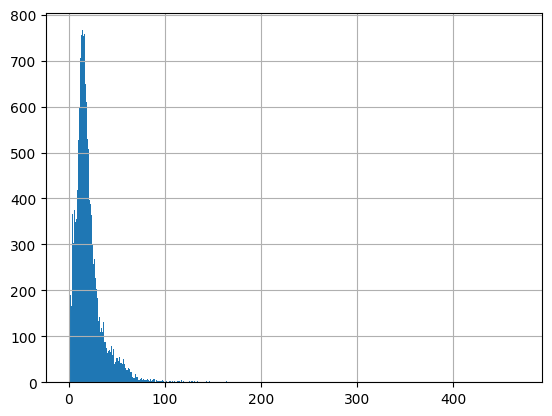

In [36]:
#Check sequence lenght
seq_len = [len(i.split()) for i in input_pre]
pd.Series(seq_len).hist(bins = max(seq_len))
#>>250

# **3. Build Vocabolary**

In [37]:
##--BUILD VOCAB--##
#create one-hot encoded vectors for label.
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes = 2, dtype = 'float32')

#Tokenize
tokenizer_data = Tokenizer(oov_token = '<OOV>', split = ' ') #add out-of-vocab is tag '<OOV>'
tokenizer_data.fit_on_texts(input_pre)

#Save Vocab
pickle.dump(tokenizer_data, open('tokenizer_data.pkl', 'wb'))

#convert text data into sequences of numerical representations of the text data based on the tokenizer's vocabulary.
#pad/truncate sequences to a fixed length (added to the end (right side) of the sequences).
tokenized_sequence = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_sequence, maxlen =250, padding = 'post')



# **4. Data Splitting**

In [38]:
#split data
vocab_size = len(tokenizer_data.word_index) + 1 #+1 for OOV
X_train_val, X_test, y_train_val, y_test = train_test_split(vec_data, label_tf, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42)
print('Vocab size: ',vocab_size)
print('Training data size: ', len(X_train))
print('Validation data size: ', len(X_val))
print('Testing data size: ', len(X_test))

Vocab size:  6714
Training data size:  10915
Validation data size:  2729
Testing data size:  1516


# **5. Model Building**

In [39]:
'''
Create model combining CNN and Bi-LSTM layers to leverages the strengths of both CNNs and LSTMs to improve the model's ability
to learn and extract features from text.
CNN are good at capturing local patterns/features while Bi-LSTM can capture information from both past and future context.
'''
def generate_model():
    input_dim = vocab_size
    output_dim = 30
    input_length = 250
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))

    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=initializer)(input_layer)

    cnn = Conv1D(filters=30, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    cnn = MaxPooling1D()(cnn) #feature selection, dimension reduction
    cnn = LayerNormalization()(cnn)
    cnn = Dropout(0.3)(cnn)

    bi_lstm = Bidirectional(LSTM(units=30, dropout=0.3, return_sequences=True, kernel_initializer=initializer))(embedding_layer)
    bi_lstm = MaxPooling1D()(bi_lstm)
    bi_lstm = LayerNormalization()(bi_lstm)
    bi_lstm = Dropout(0.3)(bi_lstm)

    output_layer = tf.keras.layers.Concatenate()([cnn, bi_lstm])
    output_layer = GlobalMaxPooling1D()(output_layer) #feature selection, dimension reduction
    output_layer = LayerNormalization()(output_layer)
    output_layer = Dropout(0.3)(output_layer)

    output_layer = Dense(40, activation='relu')(output_layer)
    output_layer = Dropout(0.3)(output_layer)
    output_layer = Dense(20, activation='relu')(output_layer)
    output_layer = Dropout(0.3)(output_layer)
    output_layer = Dense(2, activation='softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

model = generate_model()
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 250, 30)              201420    ['input_3[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 250, 30)              2730      ['embedding_2[0][0]']         
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 250, 60)              14640     ['embedding_2[0][0]']         
 onal)                                                                                      

# **6. Model Training**

Epoch 1/10
546/546 [==============================] - 50s 79ms/step - loss: 0.5486 - accuracy: 0.7227 - val_loss: 0.3973 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 2/10
  1/546 [..............................] - ETA: 18s - loss: 0.3230 - accuracy: 0.8500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


546/546 [==============================] - 20s 37ms/step - loss: 0.3902 - accuracy: 0.8386 - val_loss: 0.3475 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 3/10
546/546 [==============================] - 17s 30ms/step - loss: 0.3260 - accuracy: 0.8731 - val_loss: 0.3227 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 4/10
546/546 [==============================] - 16s 29ms/step - loss: 0.2976 - accuracy: 0.8842 - val_loss: 0.3452 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 5/10
546/546 [==============================] - 14s 27ms/step - loss: 0.2557 - accuracy: 0.9005 - val_loss: 0.3727 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 6/10
546/546 [==============================] - 14s 26ms/step - loss: 0.1996 - accuracy: 0.9270 - val_loss: 0.3796 - val_accuracy: 0.8622 - lr: 2.0000e-04


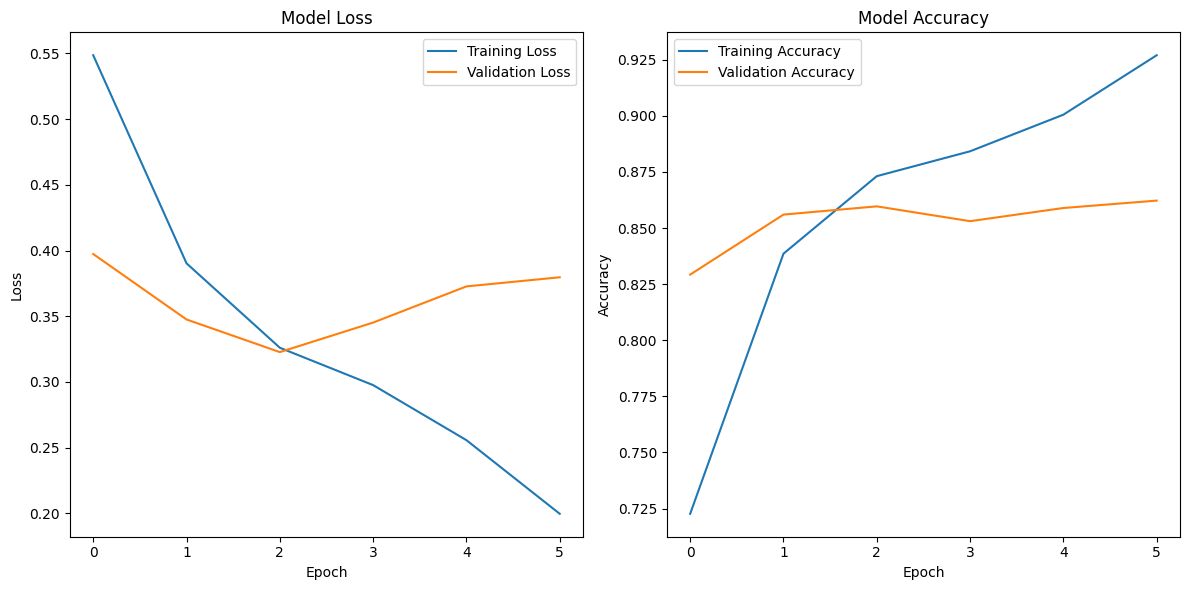

In [40]:
checkpoint  = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
early_stopping = EarlyStopping(
                              monitor='val_loss',  # Monitor validation loss
                              min_delta=0.001,      # Minimum change to be considered as an improvement
                              patience=3,           # Number of epochs with no improvement
                              mode='min',           # Minimize the monitored metric (loss)
                              restore_best_weights=True  # Restore model to the best state
                          )
reduce_lr = ReduceLROnPlateau(
                              monitor='val_loss'
                              ,factor=0.2
                              ,patience=2
                              ,min_lr=1e-6
                              )
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=20 , callbacks=[checkpoint, early_stopping, reduce_lr ])
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **7. Model Evaluation**

48/48 [==============================] - 1s 14ms/step


<Axes: >

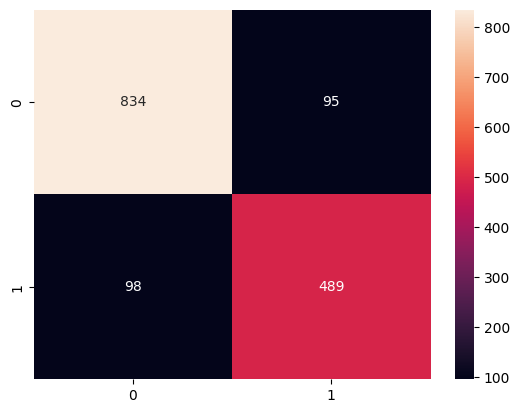

In [41]:
y_pred = model.predict(X_test)

y_prediction = []
for i in y_pred:
  y_prediction.append(np.argmax(i))

y_true = []
for i in y_test:
  y_true.append(np.argmax(i))

cm = confusion_matrix(y_true,y_prediction)
sns.heatmap(cm, annot = True, fmt='d')

In [42]:
print(classification_report(y_true, y_prediction))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       929
           1       0.84      0.83      0.84       587

    accuracy                           0.87      1516
   macro avg       0.87      0.87      0.87      1516
weighted avg       0.87      0.87      0.87      1516



**Class 0 (Positive Class):**

* Precision: 0.89 - The model has a high precision for predicting positive instances, indicating that when it predicts positive sentiment, it is often correct (89% precision).

* Recall: 0.90 - The recall for positive sentiment is high, showing that the model captures a significant portion of the actual positive instances (90% recall).

* F1-Score: 0.90 - The F1-score for positive sentiment is well-balanced, reflecting a good trade-off between precision and recall (90%).

**Class 1 (Negative Class):**
* Precision: 0.84 - The precision for predicting negative sentiment is still good, indicating that when the model predicts negative sentiment, it is often correct (84% precision).

* Recall: 0.83 - The recall for negative sentiment is relatively lower, suggesting that the model misses some of the actual negative instances (83% recall).

* F1-Score: 0.84 - The F1-score for negative sentiment is reasonable, but there is room for improvement in capturing more actual negative instances (84%).

**Accuracy:**
Overall accuracy of the model: 0.87 (87% of instances are correctly classified).

**==> The model performs well in distinguishing both positive and negative comments.
The high precision and recall values indicate a good balance between identifying positive and negative instances.**

# **7. Utilize on new dataset**

In [44]:
def pre_processing(raw_input, tokenizer):
    input_text_pre = cleaning(raw_input)
    input_text_pre_accent = word_tokenize(input_text_pre, format="text")
    tokenized_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_text, padding='post', maxlen=250)
    return vec_data

def inference_model(input_vector, model):
    output = model(input_vector).numpy()[0]
    result = output.argmax()
    conf = float(output.argmax())
    label_dict = {'Positive':0,'Negative':1}
    label = list(label_dict.keys())
    return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
    input_model = pre_processing(raw_input, tokenizer_data)
    result, conf = inference_model(input_model, model)
    return result

In [45]:
my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open('tokenizer_data.pkl', 'rb') as input_file:
    tokenizer_data = pickle.load(input_file)

df_Laz_Crawl = pd.read_csv('Laz_Crawl.csv')

df_Laz_Crawl['Comments_merge'] = df_Laz_Crawl['Comments'].fillna(df_Laz_Crawl['Comments_extra'])
df_Laz_Crawl['Comments_Cleaned'] = df_Laz_Crawl['Comments_merge'].apply(cleaning)
df_Laz_Crawl['predicted_sentiment'] = df_Laz_Crawl['Comments_merge'].apply(lambda x: prediction(x, tokenizer_data, my_model))
df_Laz_Crawl

,User_name,Category,Comments,Comments_extra,Comments_merge,Comments_Cleaned,predicted_sentiment
0,Do Thi Thuyet,Màu : A05 - cam đỏ,NaN,Bình thường,Bình thường,bình thường,Negative
1,Ly Phạm,Màu : A06 - đỏ nâu,NaN,Hài lòng,Hài lòng,hài lòng,Positive
2,Tuyền Mèo,Màu : A11 - hồng cháy,NaN,Bình thường,Bình thường,bình thường,Negative
3,Bắp Bắp,Màu : A12 - nâu gạch,NaN,Hài lòng,Hài lòng,hài lòng,Positive
4,Dương Lê,Màu : A10 - đỏ berry,NaN,Rất không hài lòng,Rất không hài lòng,rất không hài lòng,Negative
...,...,...,...,...,...,...,...
1856,Huyền Phạm,Màu : A12 - nâu gạch,đây là lần đầu tiên mik mua hàng ở tiki và rất...,Cực kì hài lòng,đây là lần đầu tiên mik mua hàng ở tiki và rất...,đây là lần đầu tiên mình mua hàng ở tiki và rấ...,Positive
1857,Cao Thanh Nhàn,Màu : A15 - nâu ánh đỏ,sau khi nhận đc hàng thì hài lòng vô cùng ạ. ...,vé rì gút !!,sau khi nhận đc hàng thì hài lòng vô cùng ạ. ...,sau khi nhận được hàng thì hài lòng vô cùng ạ ...,Positive
1858,Nguyên Hương,Màu : A06 - đỏ nâu,Thất vọng thật sự. Muốn mua 1 thỏi son lì mà ...,Cực kì hài lòng,Thất vọng thật sự. Muốn mua 1 thỏi son lì mà ...,thất vọng thật sự muốn mua 1 thỏi son lì mà te...,Negative
1859,Thảo Linh Travel,Màu : A01- đỏ dâu,"Ảnh mình chưa kịp chụp, lo test mã, và test c...",Cực kì hài lòng,"Ảnh mình chưa kịp chụp, lo test mã, và test c...",ảnh mình chưa kịp chụp lo test mã và test chất...,Positive


<Axes: xlabel='predicted_sentiment', ylabel='count'>

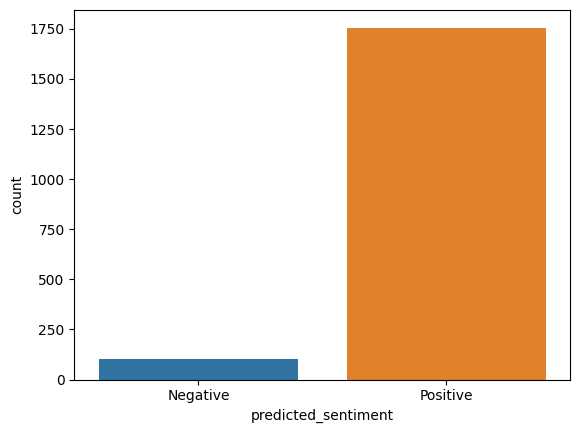

In [46]:
sns.countplot(data=df_Laz_Crawl, x='predicted_sentiment')

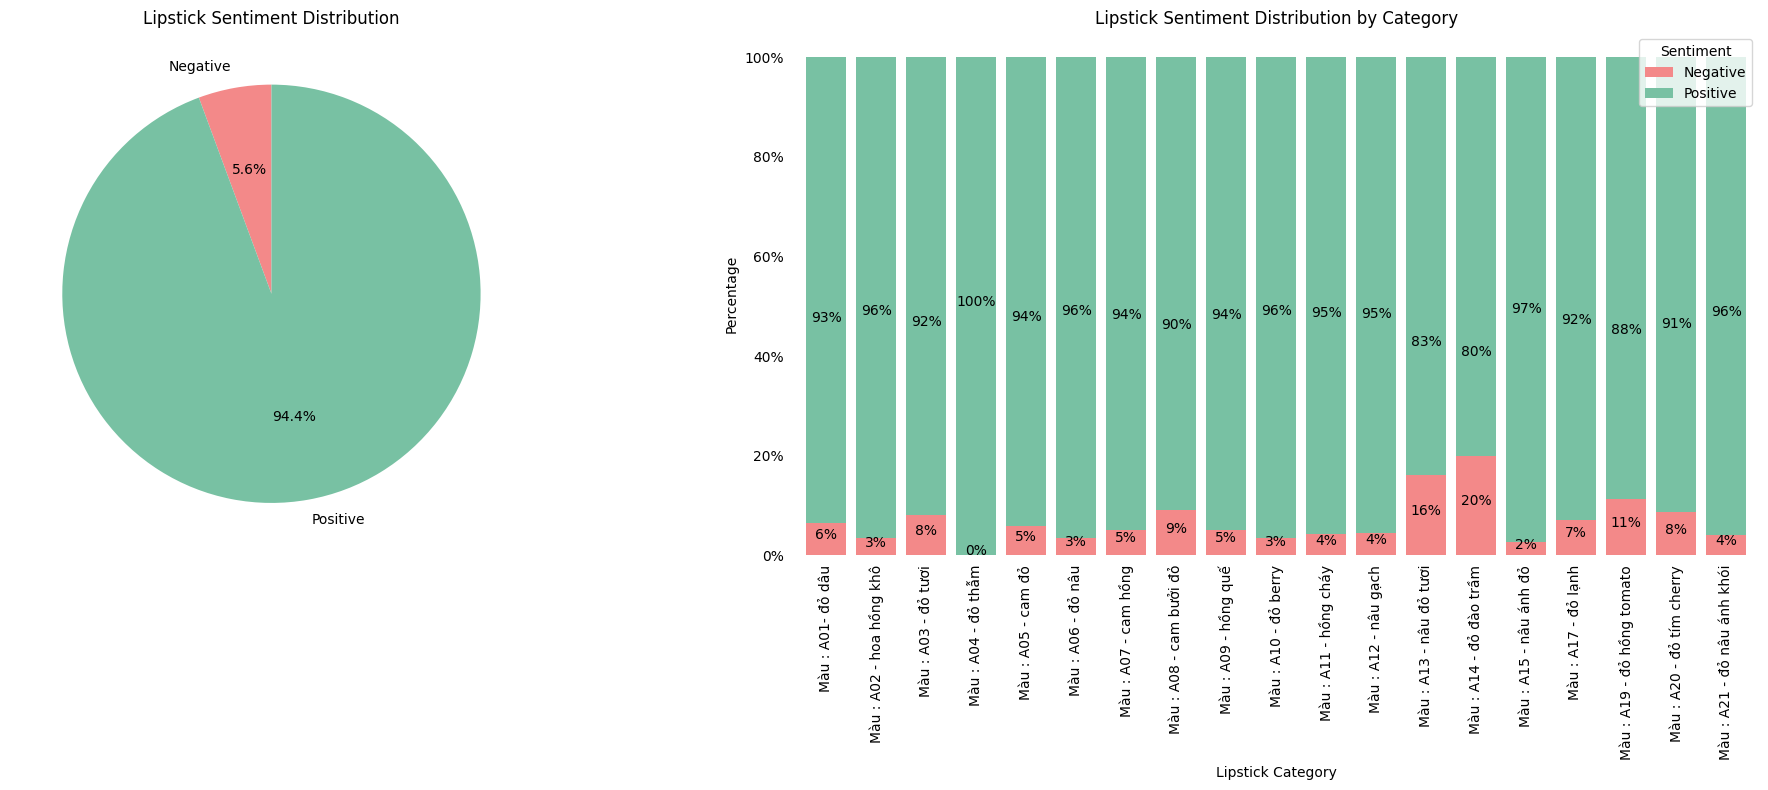

In [47]:
custom_order = ["Negative", "Positive"]
sentiment_distribution = df_Laz_Crawl['predicted_sentiment'].value_counts()[custom_order]
category_sentiment = df_Laz_Crawl.groupby('Category')['predicted_sentiment'].value_counts(normalize=True).unstack().fillna(0)[custom_order]

# Create subplots for pie chart and bar chart.
colors = {'#f38989', '#78c1a3'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Create the pie chart for sentiment distribution with percentage labels
ax1.pie(sentiment_distribution, labels=sentiment_distribution.index, colors=colors, autopct='%.1f%%', startangle=90)
ax1.set_title('Lipstick Sentiment Distribution')

# Create the bar chart for sentiment distribution by category
category_sentiment.plot(kind='bar', stacked=True, ax=ax2, width=0.8, color=colors)

ax2.set_title('Lipstick Sentiment Distribution by Category')
ax2.set_xlabel('Lipstick Category')
ax2.set_ylabel('Percentage')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='center')

# Format the y-axis labels as percentages
ax2.yaxis.set_major_formatter(PercentFormatter(1))

ax2.set_frame_on(False)
ax2.tick_params(left=False, bottom=False)

# Add labels
for i in range(len(category_sentiment)):
    for j, val in enumerate(category_sentiment.iloc[i]):
        ax2.text(i, val/2, f'{int(val * 100)}%', ha='center')

plt.legend(title='Sentiment', loc='upper right')
plt.tight_layout()
plt.show()

In [48]:
df_Laz_Crawl.to_csv('Laz_Crawl_Sentiment.csv', index=False)